# model

In [203]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score
from scipy.stats import ks_2samp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
#from skmultiflow.drift_detection import ADWIN
from xgboost import XGBClassifier
import logging


# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class TSTrendDetection:
    def __init__(self, bandwidth=1.0, adwin_delta=0.002):
        self.bandwidth = bandwidth
        self.mean_shift = MeanShift(bandwidth=self.bandwidth)
        self.scaler = StandardScaler()
#        self.adwin = {}  # ADWIN для каждой статистики
        self.available_stats = ['alpha', 'variance', 'mse', 'amplitude']
        self.classifier = None  # Для хранения обученной модели классификации

    def fit_mean_shift(self, X, use_clustering=True, stats_to_extract=["alpha"]):
        """
        Mean Shift model fitting with optional clustering and flexible statistics.
        """
        X = X.copy()

        if isinstance(X, pd.DataFrame):
            X.time = X.time.dt.total_seconds()
            X = X[['time', 'value']].values
        if not isinstance(X, np.ndarray):
            raise ValueError("X must be np.ndarray or pd.DataFrame.")

        if stats_to_extract is None:
            stats_to_extract = self.available_stats
        else:
            stats_to_extract = [s for s in stats_to_extract if s in self.available_stats]
            if not stats_to_extract:
                raise ValueError("No valid statistics specified.")

        # # Инициализация ADWIN для новых статистик
        # for stat in stats_to_extract:
        #     if stat not in self.adwin:
        #         self.adwin[stat] = ADWIN(delta=0.002)

        scaler = self.scaler
        X_scaled = scaler.fit_transform(X)

        if use_clustering:
            self.mean_shift.fit(X_scaled)
            labels = self.mean_shift.labels_
        else:
            labels = np.zeros(X.shape[0], dtype=int)

        clusters = np.unique(labels)
        clustered_ts_values = dict()
        clustered_ts_times = dict()
        clustered_stats = dict()

        for cluster in clusters:
            clustered_series = X[np.where(labels == cluster)]
            times, values, stats = self._fit_linear_regression(clustered_series, stats_to_extract)

            clustered_ts_values[cluster] = values
            clustered_ts_times[cluster] = times
            clustered_stats[cluster] = stats

        return (X, labels, clustered_ts_times, clustered_ts_values, clustered_stats)

    def _fit_linear_regression(self, clustered_series, stats_to_extract):
        """
        Fit linear regression and compute selected statistics for a cluster.
        """
        model = LinearRegression()
        X_time = clustered_series[:, 0].reshape(-1, 1)
        y_values = clustered_series[:, 1].reshape(-1, 1)
        model.fit(X_time, y_values)

        clustered_ts_value = model.predict(X_time)
        clustered_ts_time = clustered_series[:, 0]

        stats = {}
        if 'alpha' in stats_to_extract:
            stats['alpha'] = model.coef_[0][0]
        if 'variance' in stats_to_extract:
            stats['variance'] = np.var(clustered_series[:, 1]) if len(clustered_series) > 1 else 0.0
        if 'mse' in stats_to_extract:
            stats['mse'] = mean_squared_error(y_values, clustered_ts_value)
        if 'amplitude' in stats_to_extract:
            stats['amplitude'] = np.max(clustered_series[:, 1]) - np.min(clustered_series[:, 1])

        return clustered_ts_time, clustered_ts_value, stats

    def predict(self, context, model_input, params=None):
        """
        Prediction method using multiple statistics thresholds.
        """
        X, thresholds = model_input
        _, _, _, _, clustered_stats = self.fit_mean_shift(X, stats_to_extract=list(thresholds.keys()))

        anomalies = []
        for cluster_stats in clustered_stats.values():
            anomaly = False
            for stat_name, threshold in thresholds.items():
                if stat_name in cluster_stats and cluster_stats[stat_name] > threshold:
                    anomaly = True
                    break
            anomalies.append(anomaly)
        return np.array(anomalies, dtype=int)

    def downsample(self, X, smoothing_window=None, skip_window=None):
        """
        Method for time series downsampling.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Time series must be a pd.DataFrame.")
        X = X.copy()
        if smoothing_window is not None:
            X.value = X.value.rolling(window=smoothing_window, min_periods=1).median()

        if skip_window is not None:
            X.index = X.time
            X = X.value.resample(skip_window).median().fillna(0)
            X = pd.DataFrame({'time': X.index, 'value': X.values})
        return X

    def evaluate_thresholds(self, stats_matrix, labels, stats_names):
        """
        Find optimal thresholds for each statistic column using Decision Tree.

        Parameters
        ----------
        stats_matrix: np.ndarray
            Matrix where columns are statistics and rows are observations.
        labels: np.ndarray
            Labeled anomalies: 1 if anomaly, 0 otherwise.
        stats_names: list
            Names of statistics corresponding to columns in stats_matrix.

        Returns
        -------
        np.ndarray
            Array of thresholds, one for each column in stats_matrix.
        """
        stats_matrix = np.array(stats_matrix)
        labels = np.array(labels)

        if (labels == 1).all():
            return np.min(stats_matrix, axis=0)
        if (labels == 0).all():
            return np.max(stats_matrix, axis=0)

        # Проверки входных данных
        if len(stats_names) != stats_matrix.shape[1]:
            raise ValueError("stats_names must match the number of columns in stats_matrix.")
        if stats_matrix.shape[0] != len(labels):
            raise ValueError("Number of rows in stats_matrix must match length of labels.")
        if stats_matrix.shape[0] < 2:
            logging.warning("Too few observations, returning median thresholds")
            return np.array([np.median(stats_matrix[:, i]) for i in range(stats_matrix.shape[1])])

        thresholds = []
        for col_idx, stat_name in enumerate(stats_names):
            values = stats_matrix[:, col_idx]

            # Обучение решающего дерева
            X = values.reshape(-1, 1)
            y = labels
            clf = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=42)
            clf.fit(X, y)

            # Извлечение порога из корневого узла
            if clf.tree_.node_count > 1:  # Проверка, что дерево имеет разделение
                threshold = clf.tree_.threshold[0]  # Порог корневого узла

                if threshold == -2:  # -2 означает отсутствие разделения
                    logging.warning(f"No valid split for {stat_name}, using median")
                    threshold = np.median(values)
            else:
                logging.warning(f"No split in tree for {stat_name}, using median")
                threshold = np.median(values)

            # Ограничение порога
            threshold = np.clip(threshold, np.min(values), np.max(values))

            # Оценка F1
            predictions = (values > threshold).astype(int)
            f1 = f1_score(labels, predictions)
            logging.info(f"Threshold for {stat_name}: {threshold:.6f}, F1 score: {f1:.4f}")
            thresholds.append(threshold)

        return np.array(thresholds)

    def train_anomaly_classifier(self, stats_values, labels, classifier_params=None):
        """
        Train an XGBoost classifier to detect anomalies based on statistics.
        """

        default_params = {
            'max_depth': 3,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'scale_pos_weight': 5.0,
            'random_state': 42
        }
        if classifier_params:
            default_params.update(classifier_params)

        self.classifier = XGBClassifier(**default_params)
        self.classifier.fit(stats_values, labels)
        logging.info("Anomaly classifier trained successfully")


    def predict_anomaly_classifier(self, stats_values):
        """
        Predict anomalies using the trained classifier.
        """
        if self.classifier is None:
            logging.warning("No trained classifier available, returning zeros")

        predictions = self.classifier.predict(stats_values)
        logging.info(f"Predicted {np.sum(predictions)} anomalies out of {len(predictions)} samples")
        return predictions

    def detect_stats_drift(self, stats_matrix, new_stats_matrix, stats_names, window_size=100, drift_threshold=2.0, ks_pvalue=0.05):
        """
        Detect drift in the distribution of statistics between historical and new data.

        Parameters
        ----------
        stats_matrix: np.ndarray
            Historical statistics matrix (rows: observations, columns: stats).
        new_stats_matrix: np.ndarray
            New statistics matrix (rows: observations, columns: stats).
        stats_names: list
            Names of statistics corresponding to columns in stats_matrix.
        window_size: int
            Size of the historical window to consider.
        drift_threshold: float
            Z-score threshold for drift detection.
        ks_pvalue: float
            P-value threshold for KS test.

        Returns
        -------
        dict
            Dictionary with drift detection results for each statistic.
        """
        stats_matrix = np.array(stats_matrix)
        new_stats_matrix = np.array(new_stats_matrix)

        if len(stats_names) != stats_matrix.shape[1] or len(stats_names) != new_stats_matrix.shape[1]:
            raise ValueError("stats_names must match the number of columns in stats_matrix and new_stats_matrix.")
        if stats_matrix.shape[0] < window_size or new_stats_matrix.shape[0] < 10:
            logging.info("Insufficient data for drift detection")
            return {stat_name: {'drift_detected': False, 'stats': {}} for stat_name in stats_names}

        results = {}
        for col_idx, stat_name in enumerate(stats_names):
            historical_values = stats_matrix[-window_size:, col_idx] if stats_matrix.shape[0] > window_size else stats_matrix[:, col_idx]
            new_values = new_stats_matrix[:, col_idx]

            current_mean = np.mean(new_values)
            current_std = np.std(new_values) if len(new_values) > 1 else 0.0
            historical_mean = np.mean(historical_values)
            historical_std = np.std(historical_values) if len(historical_values) > 1 else 0.0

            drift_detected = False
            stats = {
                'current_mean': current_mean,
                'current_std': current_std,
                'historical_mean': historical_mean,
                'historical_std': historical_std
            }


            if historical_std > 0:
                z_score = abs(current_mean - historical_mean) / historical_std
                if z_score > drift_threshold:
                    ks_stat, p_value = ks_2samp(historical_values, new_values)
                    if p_value < ks_pvalue:
                        drift_detected = True
                        logging.info(f"Drift detected for {stat_name}: z-score={z_score:.2f}, KS p-value={p_value:.4f}")
                    else:
                        logging.info(f"Drift not confirmed for {stat_name}: p-value={p_value:.4f}")
                else:
                    logging.info(f"No significant drift for {stat_name}: z-score={z_score:.2f}")
            else:
                logging.warning(f"Historical std is zero for {stat_name}, skipping z-score check")

            results[stat_name] = {
                'drift_detected': drift_detected,
                'stats': stats
            }

        return results

    def detect_stats_drift_adwin(self, stats_matrix, new_stats_matrix, stats_names):
        """
        Detect drift in statistics using ADWIN.

        Parameters
        ----------
        stats_matrix: np.ndarray
            Historical statistics matrix (rows: observations, columns: stats).
        new_stats_matrix: np.ndarray
            New statistics matrix (rows: observations, columns: stats).
        stats_names: list
            Names of statistics corresponding to columns in stats_matrix.

        Returns
        -------
        dict
            Dictionary with drift detection results for each statistic.
        """
        stats_matrix = np.array(stats_matrix)
        new_stats_matrix = np.array(new_stats_matrix)

        if len(stats_names) != stats_matrix.shape[1] or len(stats_names) != new_stats_matrix.shape[1]:
            raise ValueError("stats_names must match the number of columns in stats_matrix and new_stats_matrix.")
        if new_stats_matrix.shape[0] < 1:
            logging.info("No new data provided for ADWIN drift detection")
            return {stat_name: {'drift_detected': False, 'stats': {}} for stat_name in stats_names}

        results = {}
        for col_idx, stat_name in enumerate(stats_names):
            new_values = new_stats_matrix[:, col_idx]
            drift_detected = False
            stats = {
                'current_mean': np.mean(new_values) if len(new_values) > 0 else 0.0,
                'n_values': len(new_values)
            }

            if stat_name not in self.adwin:
                self.adwin[stat_name] = ADWIN(delta=0.002)

            # Добавляем исторические данные в ADWIN
            historical_values = stats_matrix[:, col_idx]
            for value in historical_values:
                self.adwin[stat_name].add_element(value)

            # Проверяем новые данные
            for value in new_values:
                self.adwin[stat_name].add_element(value)
                if self.adwin[stat_name].detected_change():
                    drift_detected = True
                    logging.info(f"ADWIN drift detected for {stat_name} at value={value:.4f}, window size={self.adwin[stat_name].width}")

            stats['adwin_window_size'] = self.adwin[stat_name].width
            stats['adwin_mean'] = self.adwin[stat_name].estimation
            stats['drift_detected'] = drift_detected

            results[stat_name] = {
                'drift_detected': drift_detected,
                'stats': stats
            }

        return results

    def detect_anomalies(self, stats_matrix, new_stats_matrix, stats_names = None, method='isolation_forest', contamination=0.1, **kwargs):
        """
        Detect anomalies in new_stats_matrix using SOTA anomaly detection methods.

        Parameters
        ----------
        stats_matrix: np.ndarray
            Historical statistics matrix (rows: observations, columns: stats).
        new_stats_matrix: np.ndarray
            New statistics matrix (rows: observations, columns: stats).
        stats_names: list
            Names of statistics corresponding to columns in stats_matrix.
        method: str
            Anomaly detection method: 'isolation_forest', 'one_class_svm', 'lof', 'dbscan'.
        contamination: float
            Expected proportion of anomalies (0.0 to 0.5).
        **kwargs: dict
            Additional parameters for the chosen method.

        Returns
        -------
        dict
            Dictionary with:
            - 'anomalies': np.ndarray of bools (True for anomalies in new_stats_matrix).
            - 'stats': dict with method-specific statistics.
        """
        stats_matrix = np.array(stats_matrix)
        new_stats_matrix = np.array(new_stats_matrix)

        if stats_names:
            if len(stats_names) != stats_matrix.shape[1] or len(stats_names) != new_stats_matrix.shape[1]:
                raise ValueError("stats_names must match the number of columns in stats_matrix and new_stats_matrix.")
        if new_stats_matrix.shape[0] < 5:
            logging.warning("Too few observations in new_stats_matrix, returning no anomalies")
            return {
                'anomalies': np.zeros(new_stats_matrix.shape[0], dtype=bool),
                'stats': {'n_anomalies': 0}
            }

        # Нормализация данных
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(stats_matrix)
        X_test_scaled = scaler.transform(new_stats_matrix)

        # Выбор метода детекции
        if method == 'isolation_forest':
            model = IsolationForest(
                contamination=contamination,
                random_state=42,
                **kwargs
            )
            model.fit(X_train_scaled)
            predictions = model.predict(X_test_scaled)
            anomalies = predictions == -1

        elif method == 'one_class_svm':
            model = OneClassSVM(
                nu=contamination,
                kernel='rbf',
                **kwargs
            )
            model.fit(X_train_scaled)
            predictions = model.predict(X_test_scaled)
            anomalies = predictions == -1

        elif method == 'lof':
            model = LocalOutlierFactor(
                n_neighbors=min(20, new_stats_matrix.shape[0] - 1),
                contamination=contamination,
                novelty=True,
                **kwargs
            )
            model.fit(X_train_scaled)
            predictions = model.predict(X_test_scaled)
            anomalies = predictions == -1

        elif method == 'dbscan':
            model = DBSCAN(
                eps=kwargs.get('eps', 0.5),
                min_samples=kwargs.get('min_samples', 5),
                **kwargs
            )
            predictions = model.fit_predict(X_test_scaled)
            anomalies = predictions == -1

        else:
            raise ValueError(f"Unsupported method: {method}")

        # Статистики
        n_anomalies = np.sum(anomalies)
        stats = {
            'n_anomalies': n_anomalies,
            'method': method,
            'contamination': contamination
        }

        # Логирование
        logging.info(f"Anomalies detected: {n_anomalies} out of {new_stats_matrix.shape[0]} samples using {method}")

        return {
            'anomalies': anomalies,
            'stats': stats
        }

#Import

In [113]:
import pandas as pd
import numpy as np

In [2]:
DATAPAH = '/content/drive/MyDrive/Colab Notebooks/Uvelka/Data/'

In [3]:
raw_data = pd.read_csv(DATAPAH + 'sensor_data.csv', parse_dates=['timestamp'])

In [4]:
np.unique(raw_data.device.values)

array(['Токовый губки  Афл3.1', 'Токовый губки  Афл3.2',
       'Токовый губки  Афл3.3', 'Токовый губки  Афл3.4',
       'Токовый губки  Афл3.5', 'Токовый губки  Афл3.6',
       'Токовый нипроллер  Афл3.1', 'Токовый нипроллер  Афл3.2',
       'Токовый нипроллер  Афл3.3', 'Токовый нипроллер  Афл3.4',
       'Токовый нипроллер  Афл3.5', 'Токовый нипроллер  Афл3.6',
       'Токовый ремни  Афл3.1', 'Токовый ремни  Афл3.2',
       'Токовый ремни  Афл3.3', 'Токовый ремни  Афл3.4',
       'Токовый ремни  Афл3.5', 'Токовый ремни  Афл3.6'], dtype=object)

In [5]:
df = raw_data[(raw_data.device == 'Токовый нипроллер  Афл3.1') & (raw_data.timestamp > "2024-12-13 00:00:00") & (raw_data.timestamp < "2024-12-14 00:00:00")].copy()

#Stage 1
Сбор статистик

In [206]:
model = TSTrendDetection(bandwidth = 1.0)

In [8]:
df_input = pd.DataFrame()

In [9]:
df_input[['time','value']] = df[['timestamp','amperage']].copy()

In [76]:
df_input.head(10)

,time,value
527028,2024-12-13 00:00:01,0.104239
527041,2024-12-13 00:00:17,15.348526
527054,2024-12-13 00:00:32,21.283280
527067,2024-12-13 00:00:48,0.692127
527081,2024-12-13 00:01:00,2.545637
527094,2024-12-13 00:01:20,6.220177
527108,2024-12-13 00:01:31,6.244355
527121,2024-12-13 00:01:47,0.578613
527134,2024-12-13 00:02:03,2.570428
527147,2024-12-13 00:02:18,0.212109


In [11]:
# Если есть skip_window, то ВР группируется по этому параметру.
# Пример есть 3 наблюдения за 1 минуту (1 min 12 sec: 5) (1 min 36 sec: 7) (1 min 47 sec: 9)
# Три наблюдения группируется в одно (1 min 0 sec: 7)
df_down_sampled = model.downsample(df_input, smoothing_window = 20*60, skip_window = '60s')

In [12]:
df_down_sampled['timedate'] = df_down_sampled['time']

In [13]:
df_down_sampled['time'] = pd.to_timedelta(df_down_sampled.time - df_down_sampled.time.iloc[0], unit='s')

Выбираем какие статистики хотим извлечь из ВР

В методе _fit_linear_regression можно настраивать какие статистики собирать (В будущем есть смысл использовать методы сбора статистик, например, из tsfresh как аргументы)

Теперь есть выбор использовать только alpha или другие статистики

In [27]:
#(X, labels, clustered_ts_times, clustered_ts_values, clustered_stats)
%%time
data, cluster_labels, clustered_times, clustered_values, clustered_stats = model.fit_mean_shift(df_down_sampled, stats_to_extract = ['alpha', 'variance'])

CPU times: user 4.81 s, sys: 19.4 ms, total: 4.83 s
Wall time: 4.87 s


In [28]:
clustered_stats

{np.int64(0): {'alpha': np.float64(-3.5955902993876135e-05),
  'variance': np.float64(2.599887778766541)},
 np.int64(1): {'alpha': np.float64(0.0004146853068516877),
  'variance': np.float64(9.801057893334399)},
 np.int64(2): {'alpha': np.float64(-0.000247693066272014),
  'variance': np.float64(8.570470091300672)}}

In [29]:
pd.DataFrame(clustered_stats).T.to_numpy()

array([[-3.59559030e-05,  2.59988778e+00],
       [ 4.14685307e-04,  9.80105789e+00],
       [-2.47693066e-04,  8.57047009e+00]])

## Обучение с учителем

In [30]:
x_train = pd.DataFrame(clustered_stats).T.to_numpy()

#Отметили кластер 0 как аномалию, и кластер 1 как норму (метки: 1 - аномалия, 0 - норм)
labels = {
    0: 0,
    1: 1,
    2: 0,
}

labels = np.array(list(labels.values()))
y_train = labels

### Простое "обучение"

Модель возвращает пороги по которым можно отделять нормальный сигнал от аномального. (Пороги для каждой фичи вычисляются в не зависимости от остальных фич - "будто бы других столбцов нет")
Больше подходит для тестирований и проверки идей

In [35]:
best_thresholds = model.evaluate_thresholds(x_train, y_train, ["alpha","variance"])

In [36]:
best_thresholds

array([1.89364708e-04, 9.18576384e+00])

In [43]:
# alpha
print("Predicted:", (x_train[:,0] > best_thresholds[0]).astype(int), "\n")
print("True:", y_train)

Predicted: [0 1 0] 

True: [0 1 0]


In [44]:
# variance
print("Predicted:", (x_train[:,1] > best_thresholds[1]).astype(int), "\n")
print("True:", y_train)

Predicted: [0 1 0] 

True: [0 1 0]


Нужно когда наблюдений мало.
Или для проверки идей, так как с такиф форматом данных намного проще работать, чем с весами в моделе

### Классификатор аномалий

Используется когда данных много (больше подходит для прода)

In [50]:
x_train = np.array([[-3.595e-05, 2.5998], [0.4146, 9.80], [-0.000247, 8.5704], [7e-7, 6.5704], [7e-5, 5], [3e-5, 3], [7e-5, 6], [8e-5, 7], [2e-3, 9], [9e-1,14], [9,12]])
labels = {
    0: 0,
    1: 1,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 1,
    10: 1,
}
y_train = np.array(list(labels.values()))

In [54]:
model.train_anomaly_classifier(x_train, y_train)

In [60]:
# Аномалии: 1 1
model.predict_anomaly_classifier([[3,5], [3,1]])

array([1, 1])

In [72]:
#Не аномалии: 0 0
model.predict_anomaly_classifier([[1e-6,9], [1e-6,1]])

array([0, 0])

Даже на таком небольшом наборе данных модель уловила что alpha важнее чем variance

In [67]:
model.classifier.feature_importances_

array([1., 0.], dtype=float32)

## Обучение без учителя

! Будет основано на выявлении выбросов и дрейфе данных

### Выявлении выбросов

Если какая-то одна или несколько статистик резко изменяются

In [118]:
np.random.seed(42)

In [119]:
time = np.arange(0, 300)
old_data = 0.1*np.sin(time / 10) + np.random.normal(scale=0.5, size=time.shape)

<Axes: >

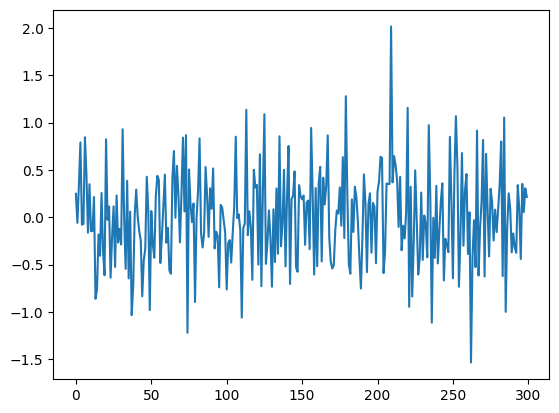

In [121]:
pd.Series(old_data).plot()

In [130]:
np.random.seed(42)

new_time = np.arange(0, 30)
new_data = 0.1*np.sin(new_time / 10) + np.random.normal(scale=0.5, size=new_time.shape)
# Добавлен резкий переход
new_data[-10:] += 0.7

<Axes: >

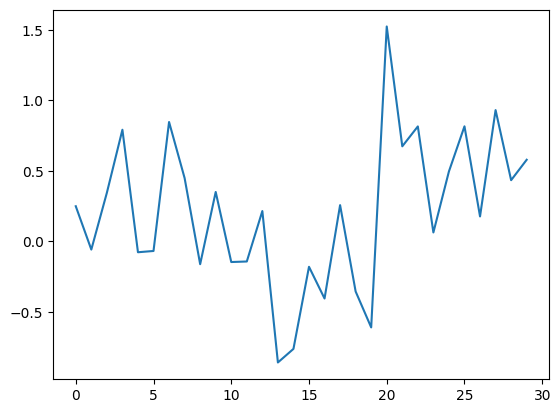

In [131]:
pd.Series(new_data).plot()

In [150]:
new_data.shape

(30,)

In [152]:
new_data.reshape(-1, 1).shape

(30, 1)

In [158]:
# stats_names только для отчетности чтобы сохранялось какие именно фичи проверяли
result = model.detect_anomalies(old_data.reshape(-1, 1), new_data.reshape(-1, 1), contamination=0.05)

In [159]:
print(result)

{'anomalies': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False]), 'stats': {'n_anomalies': np.int64(1), 'method': 'isolation_forest', 'contamination': 0.05}}


In [175]:
# stats_names только для отчетности чтобы сохранялось какие именно фичи проверяли
result = model.detect_anomalies(old_data.reshape(-1, 1), new_data.reshape(-1, 1), stats_names = ['alpha'], contamination=0.5)

In [176]:
print(result)

{'anomalies': array([False,  True, False,  True,  True, False,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True]), 'stats': {'n_anomalies': np.int64(18), 'method': 'isolation_forest', 'contamination': 0.5}}


Нужно будет порог подбирать для нормальной работы...

### Дрейф данных

In [170]:
np.random.seed(42)
normal_time = np.arange(0, 300)
normal_data = 0.1*np.sin(normal_time / 10) + np.random.normal(scale=0.5, size=normal_time.shape)


<Axes: >

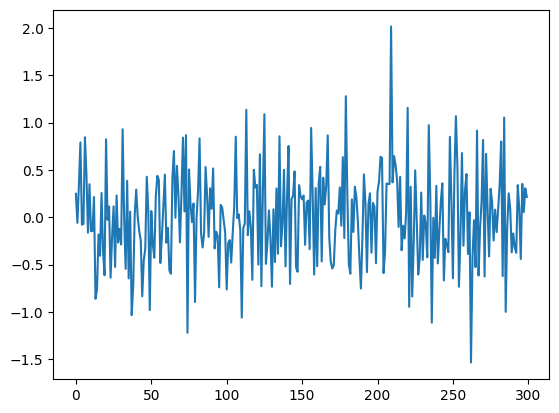

In [172]:
pd.Series(normal_data).plot()

Предположим что произошел плавный переход

In [219]:
np.random.seed(42)
drift_time = np.arange(0, 300)
drift_data = 0.1*np.sin(time / 10) + np.random.normal(scale=0.5, size=time.shape)

drift_data[100:] += (np.array(list(range(0, 200))) / 40)


<Axes: >

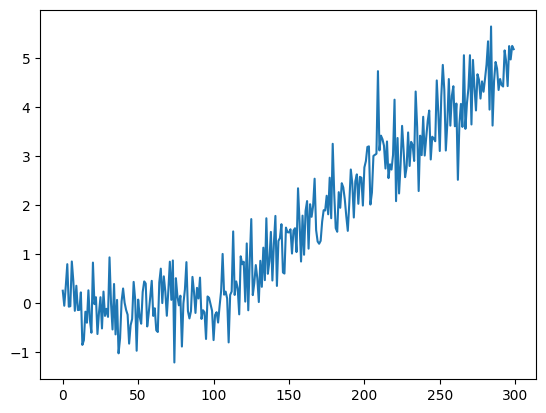

In [220]:
pd.Series(drift_data).plot()

In [221]:
model.detect_stats_drift(normal_data.reshape(-1, 1), drift_data.reshape(-1, 1), stats_names = ['alpha'])

{'alpha': {'drift_detected': True,
  'stats': {'current_mean': np.float64(1.6585405378705986),
   'current_std': np.float64(1.7521903110493804),
   'historical_mean': np.float64(0.035934805499166694),
   'historical_std': np.float64(0.5465150659656033)}}}

Если данные не менялись

In [196]:
np.random.seed(42)
drift_time = np.arange(0, 300)
drift_data = 0.1*np.sin(time / 10) + np.random.normal(scale=0.5, size=time.shape)

<Axes: >

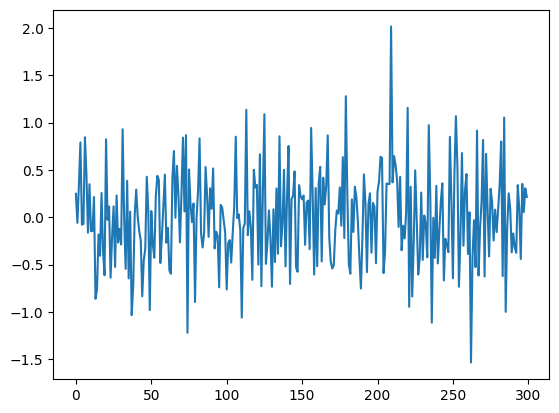

In [204]:
pd.Series(drift_data).plot()

In [207]:
model.detect_stats_drift(normal_data.reshape(-1, 1), drift_data.reshape(-1, 1), stats_names = ['alpha'])

{'alpha': {'drift_detected': False,
  'stats': {'current_mean': np.float64(0.0002072045372650096),
   'current_std': np.float64(0.492917012536287),
   'historical_mean': np.float64(0.035934805499166694),
   'historical_std': np.float64(0.5465150659656033)}}}

Со износом оборудования статистики будут меняться отклоняться от номинального значения, этот тест нужен для того чтобы такие ситуации отлавливать

1. Стоит добавить сбор статистик через tsfresh в _fit_linear_regression
2. Для проверки отклонения статистик можно использовать ruptures (change point detection)